✅ 保存参数表: PKL_DATA/violin_plots/larbi_leaky_params_with_groups.csv
✅ 保存t检验结果: PKL_DATA/violin_plots/t_test_results_larbi_leaky.csv

=== Welch's t-test Results ===
  parameter  healthy_mean  patient_mean    t_stat   p_value  n_healthy  \
0      leak      3.022206      4.369466 -1.883373  0.062675         46   
1   alpha_u      0.302030      0.256687  0.727754  0.468557         46   
2      beta      0.144532      0.139084  0.265241  0.791435         46   
3       tau      4.094135      4.299669 -0.244056  0.807712         46   
4     theta      0.307660      0.294087  0.196539  0.844611         46   
5     alpha      0.485019      0.476319  0.174465  0.861864         46   

   n_patient  
0         53  
1         53  
2         53  
3         53  
4         53  
5         53  

✅ 单图已保存：
 - PKL_DATA/violin_plots/violin_alpha.png
 - PKL_DATA/violin_plots/violin_beta.png
 - PKL_DATA/violin_plots/violin_alpha_u.png
 - PKL_DATA/violin_plots/violin_theta.png
 - PKL_DATA/violin_plots/violin_lea

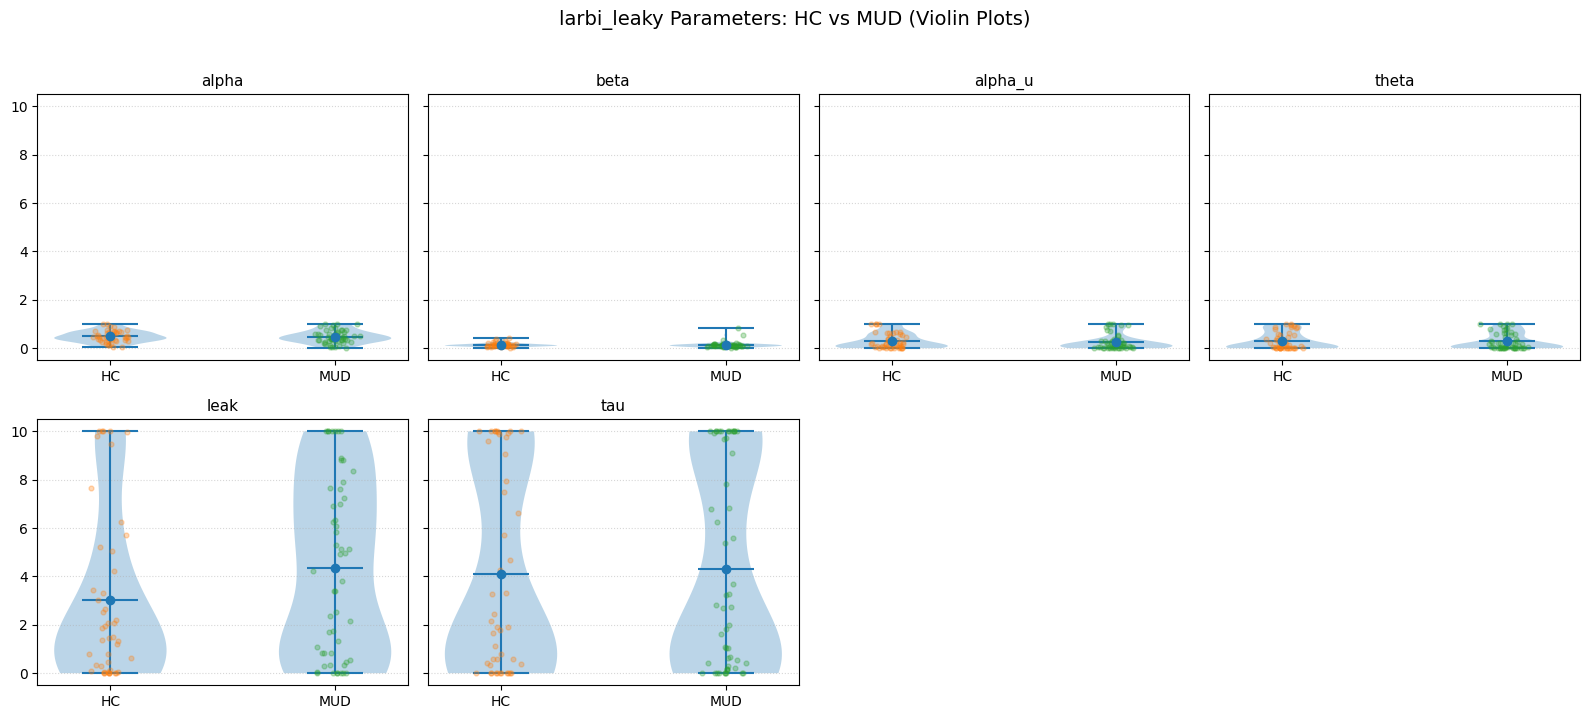


✅ 拼图已保存： PKL_DATA/violin_plots/violin_grid_2x4.png


In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from pathlib import Path

# ======================
# 1. 读取数据
# ======================
fit_path = "PKL_DATA/fitdata/fitresults_ALL_larbi_leaky.pkl"
subj_path = "PKL_DATA/ALL_SUBJECTS.pkl"
out_dir   = Path("PKL_DATA/violin_plots")
out_dir.mkdir(parents=True, exist_ok=True)

# 读取拟合结果（list of dict）
with open(fit_path, "rb") as f:
    fit_list = pickle.load(f)

# 读取被试信息（dict: subj_id -> DataFrame）
with open(subj_path, "rb") as f:
    subj_dict = pickle.load(f)

# ======================
# 2. 构建参数表
# ======================
subj_ids = list(subj_dict.keys())  # 拟合时的被试顺序
assert len(subj_ids) == len(fit_list), \
    f"被试数({len(subj_ids)})与fit结果数({len(fit_list)})不一致，请检查。"

param_names = fit_list[0]["param_name"]  # larbi_star 模型的所有参数

rows = []
for sid, fr in zip(subj_ids, fit_list):
    # 每一行 = 一个被试
    row = {"subj": sid}
    row["group"] = "patient" if "Q" in sid.upper() else "healthy"
    for name, val in zip(param_names, fr["param"]):
        row[name] = float(val)
    rows.append(row)

df = pd.DataFrame(rows)

# 保存一个干净的参数表，方便检查
df.to_csv(out_dir / "larbi_leaky_params_with_groups.csv", index=False)
print(f"✅ 保存参数表: {out_dir / 'larbi_leaky_params_with_groups.csv'}")

# 标准化分组标签用于作图
df["Group2"] = np.where(df["group"].str.lower().eq("patient"), "MUD", "HC")
healthy_df = df[df["Group2"] == "HC"]
patient_df = df[df["Group2"] == "MUD"]

# ======================
# 3. Welch's t-test
# ======================
results = []
for param in param_names:
    x = healthy_df[param].dropna().values
    y = patient_df[param].dropna().values
    t_stat, p_val = ttest_ind(x, y, equal_var=False)  # Welch's t-test
    results.append({
        "parameter": param,
        "healthy_mean": float(np.mean(x)),
        "patient_mean": float(np.mean(y)),
        "t_stat": float(t_stat),
        "p_value": float(p_val),
        "n_healthy": int(x.size),
        "n_patient": int(y.size)
    })

# 转换为 DataFrame 并按 p 值排序
df_ttest = pd.DataFrame(results).sort_values("p_value").reset_index(drop=True)

# 保存结果表
df_ttest.to_csv(out_dir / "t_test_results_larbi_leaky.csv", index=False)
print(f"✅ 保存t检验结果: {out_dir / 't_test_results_larbi_leaky.csv'}")

# 显示结果
print("\n=== Welch's t-test Results ===")
print(df_ttest)

# ======================
# 4. 画图：单参数小提琴（8张）
#   - matplotlib 自带 violinplot
#   - 叠加均值点 + 轻微抖动散点（便于看单个被试分布）
# ======================
def jitter(n, loc):
    """轻微横向抖动，避免散点完全重叠"""
    return np.random.normal(loc, 0.04, size=n)

single_paths = []
for param in param_names:
    x = healthy_df[param].dropna().values
    y = patient_df[param].dropna().values

    fig = plt.figure(figsize=(5, 4))
    ax  = plt.gca()

    # violin
    ax.violinplot([x, y], showmeans=True, showextrema=True, showmedians=False)

    # 坐标与标题
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["HC", "MUD"])
    ax.set_ylabel(param)
    ax.set_title(f"{param}: HC vs MUD")

    # 叠加均值点
    ax.scatter([1, 2], [np.mean(x), np.mean(y)], zorder=3)

    # 抖动散点（透明度低一点）
    ax.scatter(jitter(len(x), 1.0), x, alpha=0.35, s=18, zorder=2)
    ax.scatter(jitter(len(y), 2.0), y, alpha=0.35, s=18, zorder=2)

    ax.grid(True, axis='y', linestyle=':', alpha=0.5)
    fig.tight_layout()

    out_png = out_dir / f"violin_{param}.png"
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close(fig)

    single_paths.append(out_png)

print("\n✅ 单图已保存：")
for p in single_paths:
    print(" -", p)

# ======================
# 5. 画图：2×4 拼图（统一 y 轴，观感统一）
# ======================
all_vals = np.concatenate([df[p].dropna().values for p in param_names])
ymin, ymax = np.percentile(all_vals, [1, 99])  # 去掉极端尾部
pad = 0.05 * (ymax - ymin)
ymin, ymax = float(ymin - pad), float(ymax + pad)

fig, axes = plt.subplots(2, 4, figsize=(16, 7), sharey=True)
axes = axes.ravel()

for ax, param in zip(axes, param_names):
    x = healthy_df[param].dropna().values
    y = patient_df[param].dropna().values

    ax.violinplot([x, y], showmeans=True, showextrema=True, showmedians=False)
    ax.set_xticks([1, 2]); ax.set_xticklabels(["HC", "MUD"])
    ax.set_title(param, fontsize=11)
    ax.scatter([1, 2], [np.mean(x), np.mean(y)], zorder=3)
    ax.scatter(jitter(len(x), 1.0), x, alpha=0.30, s=12, zorder=2)
    ax.scatter(jitter(len(y), 2.0), y, alpha=0.30, s=12, zorder=2)
    ax.set_ylim([ymin, ymax])
    ax.grid(True, axis='y', linestyle=':', alpha=0.5)

# 如果将来参数不足8，隐藏多余子图
for ax in axes[len(param_names):]:
    ax.axis("off")

fig.suptitle("larbi_leaky Parameters: HC vs MUD (Violin Plots)", y=1.02, fontsize=14)
fig.tight_layout()
big_out = out_dir / "violin_grid_2x4.png"
fig.savefig(big_out, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"\n✅ 拼图已保存： {big_out}")
